# TFG hateval2019

In [1]:
# some imports
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Python ≥3.6 is required
import sys
assert sys.version_info >= (3, 6)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))

# Settings for the visualizations
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import pandas as pd
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)


from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
english_train = pd.read_csv('./hateval2019/hateval2019_en_train.csv',index_col=0)
english_dev = pd.read_csv('./hateval2019/hateval2019_en_dev.csv',index_col=0)
english_test = pd.read_csv('./hateval2019/hateval2019_en_test.csv',index_col=0)

In [3]:
english_test.head()

,text,HS,TR,AG
id,,,,
34243,"@local1025 @njdotcom @GovMurphy Oh, I could ha...",0,0,0
30593,Several of the wild fires in #california and #...,0,0,0
31427,@JudicialWatch My question is how do you reset...,0,0,0
31694,"#Europe, you've got a problem! We must hurry...",1,0,0
31865,This is outrageous! #StopIllegalImmigration #...,1,0,0


## Basic statistical analysis

In [4]:
def plot_top_barchart(text, just_stopwords=True, k=10):
    """Plots a barchart of the `k` most common words in a corpus. 
    Depending on the option `just_stopwords` it will count the stopwords
    or the rest.
    """
    stop = set(stopwords.words('english'))
    
    new = text.str.split().values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word,count in most:
        if len(x) >= k:
            break
        if just_stopwords ^ (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)
    
def plot_top_ngrams_barchart(text, n=2, k=10):
    """Plots a barchart of the `k` most common n-grams words in a corpus. 
    """
    new = text.str.split().values.tolist()
    corpus = [word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:k]

    top_n_bigrams = _get_top_ngram(text,n)[:k]
    x,y = map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
    
    
def print_distribution_features(data):
    """Prints feature distribution of the dataset hateval2019.
    TR and AG are always dependent on HS being `True`. As checked on the last line.
    """
    print("Distribution of features:")
    print(f"HS: {100 * np.sum(data['HS'] == True) / data.shape[0]}%")
    print(f"HS -> TR: {100 * np.sum((data['HS'] == True) & (data['TR'] == True)) / np.sum(data['HS'] == True)}%")
    print(f"HS -> AG: {100 * np.sum((data['HS'] == True) & (data['AG'] == True)) / np.sum(data['HS'] == True)}%")
    print(f"HS -> TR & AG: {100 * np.sum((data['HS'] == True) & (data['TR'] == True) & (data['AG'] == True)) / np.sum(data['HS'] == True)}%")
    print(f"!HS & (TR | AG): {100 * np.sum((data['HS'] == False) & ((data['TR'] == True) | (data['AG'] == True))) / data.shape[0]}%")


def _aux_print_distribution_search_pattern(data, pattern, k=10):
    """Auxiliar method that prints the information related to a specific search.
    Such as the mentions of this pattern in each tweet, the number of unique mentions,
    the `k` most common words that fulfill the pattern.
    
    `pattern` has to be a regex to be searched and `data` has to be from the hateval2019
    dataset.
    """
    data_text = data["text"].str.findall(pattern)
    n_data = data_text.map(lambda x: len(x))
    print(f"Number of mentions per tweet (MIN, MEAN, MAX): ({n_data.min()}, {n_data.mean()}, {n_data.max()})")
    n_data_users = data_text.map(lambda x: len(x) > 0)
    print(f"Number of tweets that contain a mention: {n_data_users.mean()}")
    
    print("Most Common mentions:")
    data_1d = data_text.explode()
    most_common_data = pd.DataFrame({"Mention": data_1d.value_counts()[:k].index, "Count": data_1d.value_counts()[:k].values}).set_index("Mention")
    
    for feature in ["HS", "TR", "AG"]: # Calculates percentage the ratio of all features of the tweets that mention the data.
        most_common_data[feature] = most_common_data.index.map(lambda mention: np.mean(data.loc[data_1d[data_1d == mention].index][feature]))
    for feature in ["TR", "AG"]: # Changes the percentage of the two other features to represent if HS is True what is the percentage ratio.
        # Avoids divistion by zero, by letting be zero. As checked it will always be 0/0, so we can ignore it.
        most_common_data[feature] = np.divide(most_common_data[feature], most_common_data["HS"], out=np.zeros(most_common_data.shape[0]), where=most_common_data["HS"]!=0)
        most_common_data.rename(columns={feature:f"HS -> {feature}"}, inplace=True)

    print(most_common_data) 
    return most_common_data
    

def print_twitter_information(data):
    """Prints information related with twitter features: mentions to users and hashtags.
    Also prints the most common links.
    (trening topics).
    """
    print("\nUsers:")
    _aux_print_distribution_search_pattern(data, r"@\w*")
    
    print("\nHashtags:")
    _aux_print_distribution_search_pattern(data, r"#\w*")
    
    print("\nLinks:")
    _aux_print_distribution_search_pattern(data, r"https?\S*")
    
    print("\nNon-ascii:")
    _aux_print_distribution_search_pattern(data, r"[^\x00-\x7F]")
    
def print_tweet_characteristics(data):
    """Prints general information about the string corpus.
    """
    print("\nTweets: (MIN, MEAN, MAX)")
    n_characters = data["text"].str.len()
    print(f"Number of characters: ({n_characters.min()}, {n_characters.mean()}, {n_characters.max()})")
    n_words = data["text"].str.split().map(lambda x: len(x))
    print(f"Mean of Number of words: ({n_words.min()}, {n_words.mean()}, {n_words.max()})")
    avg_word_lenght = data["text"].str.split().map(lambda x : np.mean([len(i) for i in x]))
    print(f"Mean of Avarage word lenght: ({avg_word_lenght.min()}, {avg_word_lenght.mean()}, {avg_word_lenght.max()})")
    
    plt.figure(1)
    plt.subplot(131)

    # Characters
    n_characters.hist()
    plt.title("Number of characters")
    plt.subplot(132)
    # Words
    n_words.hist()
    plt.title("Number of words")
    plt.subplot(133)
    # Mean Characters in Words
    avg_word_lenght.hist()
    plt.title("Avarage word lenght")
    plt.show()
    

def basic_statistics_plot(orig_data, HS=None, TR=None, AG=None):
    """Method that prints and plots basic information about the dataset.
    `HS`, `TR`, `AG` will allow to filter by specific values of the features.
    """
    true_array = np.ones(orig_data.shape[0], dtype=bool)
    
    data = orig_data.loc[(true_array if HS is None else orig_data["HS"] == HS) &
                (true_array if TR is None else orig_data["TR"] == TR) &
                (true_array if AG is None else orig_data["AG"] == AG)].copy()
    
    data["text"] = data["text"].apply(lambda x: x.lower())
    
    print_distribution_features(data) # Basic feature information
    print_twitter_information(data) # Unique characteristics of tweets (like users and hashtags)
    print_tweet_characteristics(data) # Basic text information

    # Most common words
    plt.figure(2)
    plt.subplot(121)
    plot_top_barchart(data["text"], just_stopwords=True)
    plt.title("Most common stopwords")
    plt.subplot(122)
    plot_top_barchart(data["text"], just_stopwords=False)
    plt.title("Most common non-stopwords")
    
    # Most common n-grams
    plt.figure(3)
    plt.subplot(121)
    plot_top_ngrams_barchart(data["text"], n=2)
    plt.title("Most common bigrams")
    plt.subplot(122)
    plot_top_ngrams_barchart(data["text"], n=3)
    plt.title("Most common trigrams")
    plt.show()

TRAIN:

Distribution of features:
HS: 42.03333333333333%
HS -> TR: 35.448057097541636%
HS -> AG: 41.210679355009255%
HS -> TR & AG: 12.344699973565953%
!HS & (TR | AG): 0.0%

Users:
Number of mentions per tweet (MIN, MEAN, MAX): (0, 0.6873333333333334, 20)
Number of tweets that contain a mention: 0.3913333333333333
Most Common mentions:
                  Count        HS  HS -> TR  HS -> AG
Mention                                              
@realdonaldtrump    281  0.758007  0.122066  0.586854
@potus               93  0.860215  0.125000  0.562500
@isupport_israel     92  0.597826  0.127273  0.436364
@refugees            55  0.000000  0.000000  0.000000
@youtube             53  0.339623  0.111111  0.500000
@anncoulter          41  0.756098  0.741935  0.258065
@mailonline          36  0.527778  0.105263  0.368421
@                    35  0.485714  0.470588  0.411765
@tyrusmaina          35  0.000000  0.000000  0.000000
@housegop            32  0.906250  0.034483  0.655172

Hashtags:
Nu

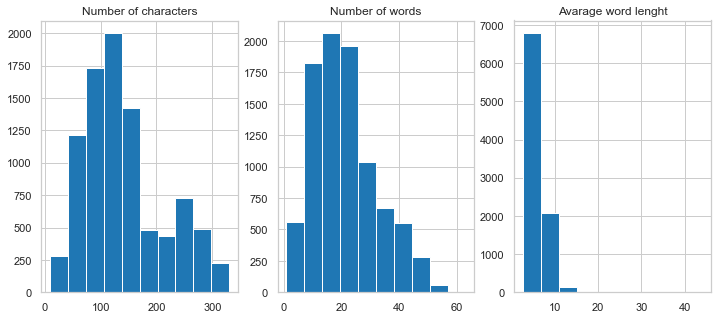

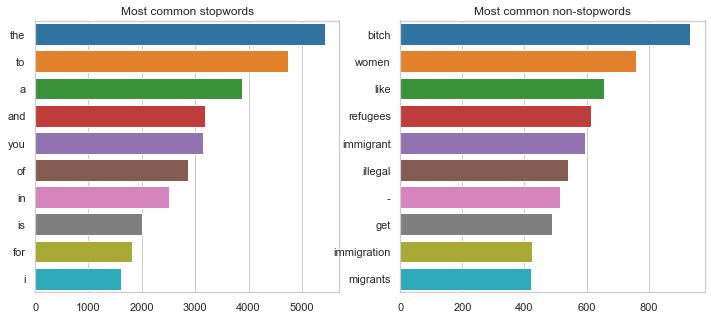

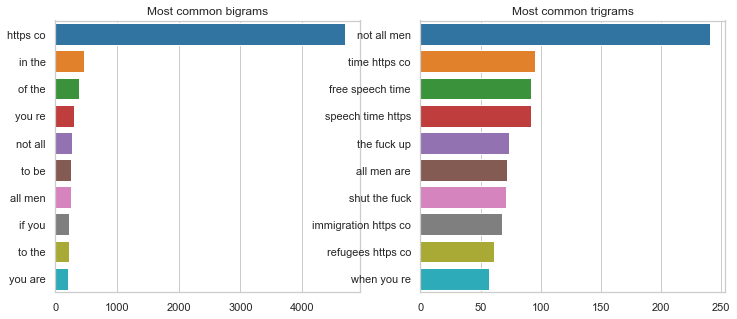



TRAIN with HS:

Distribution of features:
HS: 100.0%
HS -> TR: 35.448057097541636%
HS -> AG: 41.210679355009255%
HS -> TR & AG: 12.344699973565953%
!HS & (TR | AG): 0.0%

Users:
Number of mentions per tweet (MIN, MEAN, MAX): (0, 0.7869415807560137, 20)
Number of tweets that contain a mention: 0.4557229711868887
Most Common mentions:
                  Count   HS  HS -> TR  HS -> AG
Mention                                         
@realdonaldtrump    213  1.0  0.122066  0.586854
@potus               80  1.0  0.125000  0.562500
@isupport_israel     55  1.0  0.127273  0.436364
@anncoulter          31  1.0  0.741935  0.258065
@housegop            29  1.0  0.034483  0.655172
@senategop           23  1.0  0.043478  0.565217
@foxnews             21  1.0  0.333333  0.333333
@icegov              20  1.0  0.150000  0.650000
@mailonline          19  1.0  0.105263  0.368421
@youtube             18  1.0  0.111111  0.500000

Hashtags:
Number of mentions per tweet (MIN, MEAN, MAX): (0, 1.13111287338

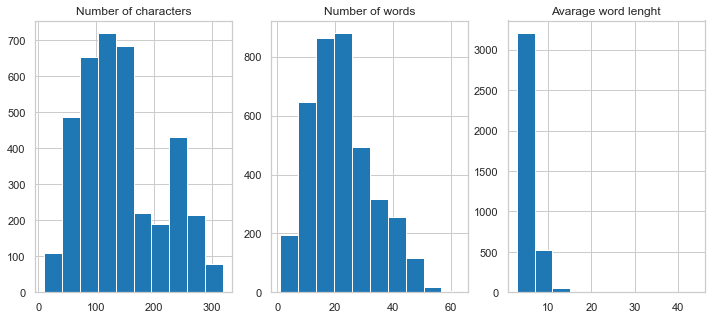

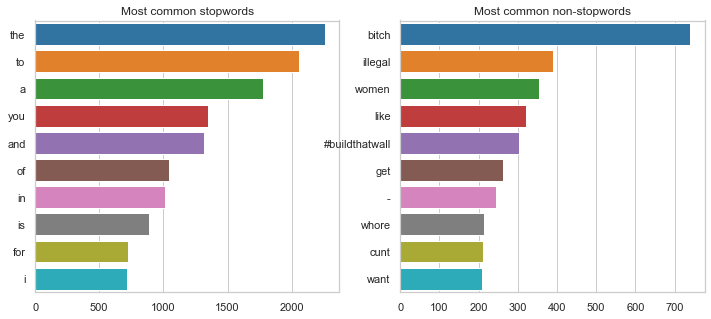

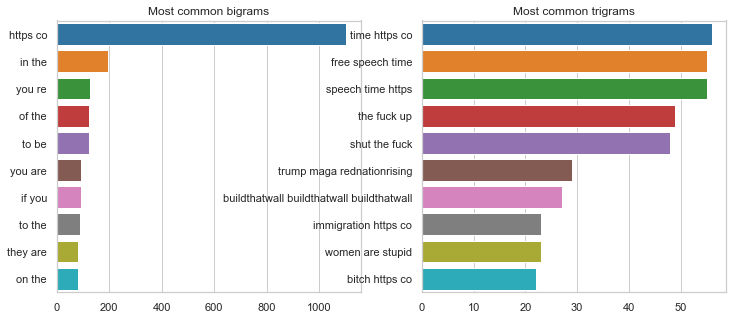



DEV:

Distribution of features:
HS: 42.7%
HS -> TR: 51.288056206088996%
HS -> AG: 47.7751756440281%
HS -> TR & AG: 25.526932084309134%
!HS & (TR | AG): 0.0%

Users:
Number of mentions per tweet (MIN, MEAN, MAX): (0, 0.922, 42)
Number of tweets that contain a mention: 0.504
Most Common mentions:
                  Count        HS  HS -> TR  HS -> AG
Mention                                              
@anncoulter          47  0.680851  0.968750  0.218750
@realdonaldtrump     35  0.571429  0.150000  0.550000
@isupport_israel     13  0.461538  0.166667  0.500000
@potus               11  0.909091  0.000000  0.600000
@youtube              9  0.111111  0.000000  0.000000
@senkamalaharris      9  1.000000  1.000000  0.111111
@corybooker           9  0.555556  1.000000  0.000000
@donaldjtrumpjr       7  0.857143  0.833333  0.166667
@housegop             6  1.000000  0.000000  1.000000
@bensasse             5  0.000000  0.000000  0.000000

Hashtags:
Number of mentions per tweet (MIN, MEAN, MA

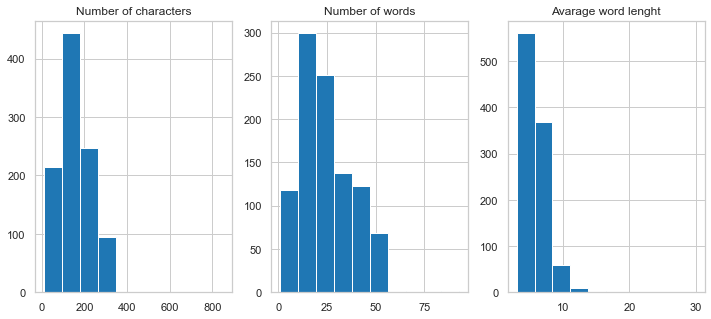

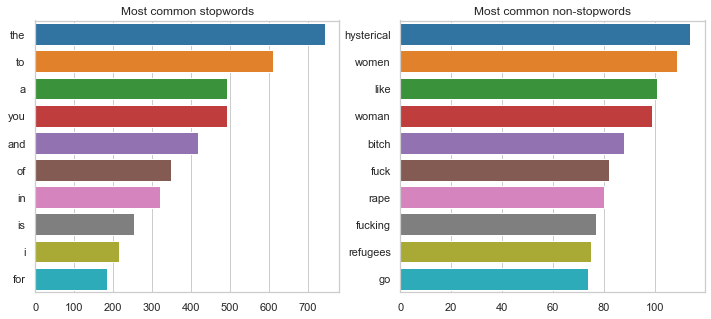

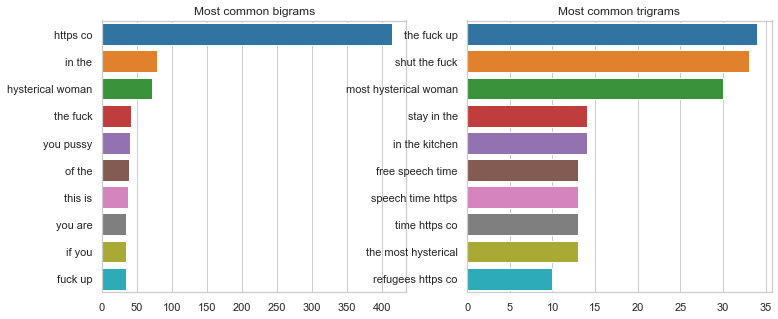



TEST:

Distribution of features:
HS: 42.0%
HS -> TR: 41.98412698412698%
HS -> AG: 47.142857142857146%
HS -> TR & AG: 14.523809523809524%
!HS & (TR | AG): 0.0%

Users:
Number of mentions per tweet (MIN, MEAN, MAX): (0, 1.0643333333333334, 40)
Number of tweets that contain a mention: 0.469
Most Common mentions:
                  Count        HS  HS -> TR  HS -> AG
Mention                                              
@realdonaldtrump    233  0.304721  0.028169  0.690141
@potus               85  0.200000  0.000000  0.647059
@realjameswoods      41  0.073171  0.000000  0.333333
@foxnews             32  0.312500  0.000000  0.600000
@speakerryan         29  0.379310  0.090909  0.454545
@housegop            28  0.821429  0.043478  0.608696
@icegov              23  0.739130  0.000000  0.764706
@gop                 22  0.454545  0.000000  0.500000
@senategop           22  0.818182  0.000000  0.722222
@                    20  0.300000  0.333333  0.333333

Hashtags:
Number of mentions per tweet

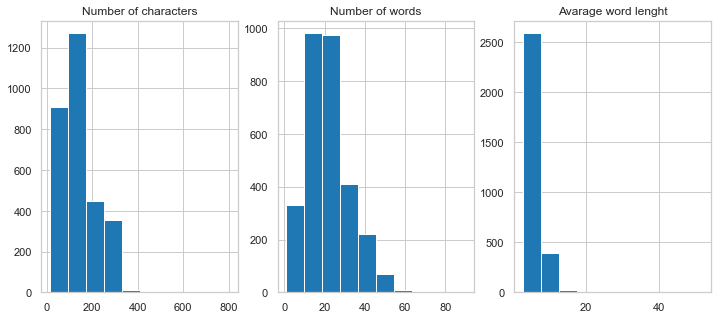

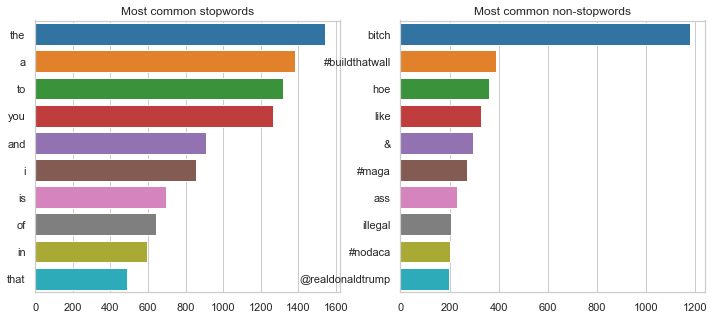

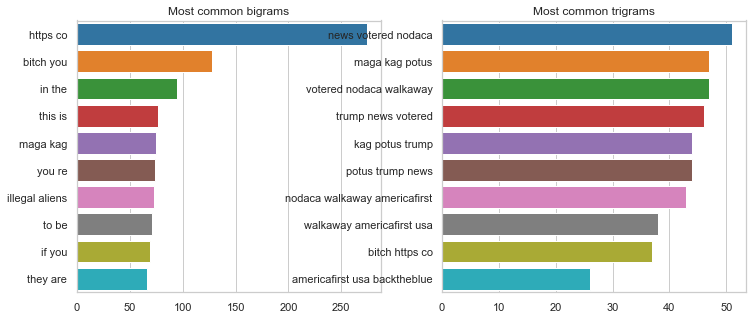

In [5]:
print("TRAIN:\n")
basic_statistics_plot(english_train)
print("\n\nTRAIN with HS:\n")
basic_statistics_plot(english_train, HS=True)
print("\n\nDEV:\n")
basic_statistics_plot(english_dev)
print("\n\nTEST:\n")
basic_statistics_plot(english_test)

## Tf-Idf
### Preprocessing

DONE:

- Remove links
- Lowercase all characters
- Remove emojis (or replaced)
- Remove stopwords
- Correct spelling mistakes
- Remove numbers (or replace by word "number")
- Replace ”&” for "and"
- Standardize blank spaces
- Normalize contractions
- Lemmatization
- Substitution of abbreviations

TODO: 

- Remove punctuation (Spanish)

In [6]:
from datetime import datetime, timedelta

def init_print_progress(n, k=10, measure_remaining_time=True, measure_avarage_time=True):
    """Inicializes the auxialiar `_print_progress()` establishing the behaviour of when
    and what should be printed.
    
    Parameters
    ----------
    n: int
        Number of iterations the auxiliar method will be called.
    k: int, default=10
        Number of iterations of when the printed data will be updated.
    measure_remaining_time: bool, default=True
        If the printed progress should display the remaining time.
    measure_avarage_time: bool, default=True
        If the remaining time should be calculated using an avarage.
        Recomended if the task load should be similar.
    """
    _print_progress._i = 1 # Number of iterations done
    _print_progress._k = k # Module of when the print will be called
    _print_progress._n = n # Total iterations to be complated
    
    _print_progress._measure_remaining_time = measure_remaining_time # If time should be tracked
    _print_progress._measure_avarage_time = measure_avarage_time # If an avarage should be used
    if measure_remaining_time:
        _print_progress._datetime = datetime.now() # Time of completion of last k iterations
        _print_progress.avargetime = timedelta() # Avarage time of the k iterations
    
def _print_progress():
    """Auxiliar method that will track progress of a fucntion. Should be called each time
    an iterations is done. Before starting the tracking, the function `init_print_progress()`
    should be called once.
    """
    _i, _k, _n = _print_progress._i, _print_progress._k, _print_progress._n
    if _i % _k == 0 or _i == _n: #Every k iterations prints or it's the last iteration
        _measure_remaining_time = _print_progress._measure_remaining_time
        if _measure_remaining_time:
            next_datetime = datetime.now()
            diff_time = next_datetime - _print_progress._datetime # Time elapsed between now and the previous k iteration
            if _print_progress._measure_remaining_time:
                _print_progress.avargetime = (_print_progress.avargetime * (_i//_k - 1) + diff_time) / (_i//_k) # Updates avarge time by adding the new elapsed time to the avarage
            else:
                _print_progress.avargetime = diff_time # Avarage time isn't tracked
            time_remaining = ((_print_progress.avargetime) / _k * (_n - _i)).total_seconds() #Calculates the time remaining
            _print_progress._datetime = next_datetime # Upadates the last time
            
        print(" "*100, end='\r') # Cleans the output
        print(f"{_i}/{_n} ({round(100*_i/_n, 2)}%)", end='') # Prints the current percentage of completion
        # Prints the calculated remaining time if specified in the inicialization. Also last iteration ends with '\n' leaving the percentage completion
        print(f" [time remaining: {int(time_remaining//3600)}:{int(time_remaining/60%60):02d}:{int(time_remaining%60):02d}]" if _measure_remaining_time else "", end='\r' if _i < _n else '\n')
    _print_progress._i += 1 # Increments the number of iterations that had happened

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.regexp import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
import re
from spellchecker import SpellChecker
from pycontractions import Contractions
import json
import os.path
import pickle

def load_dictonaries():
    """Loads the data inside the json files of all dictonaries.
    This way we avoid reconstructing the dictonary each instance.
    """
    with open('./data/simple_emojis.json') as f:
        replace_emojis.simple_emojis = json.load(f)
        
    with open('./data/complex_emojis.json') as f:
        replace_emojis.complex_emojis = json.load(f)
        
    with open('./data/abbreviations.json') as f:
        replace_abbreviations.abbreviations = json.load(f) 

def replace_emojis(text, lenguage='en'):
    """Replaces all emojis with the meaning in the dictionary. Extra 
    spaces are added to both sides to avoid case where a word or 
    another emoji aren't separated.
    """
    simple_emojis = replace_emojis.simple_emojis
    for emoji, meaning in simple_emojis.items():
        text = text.replace(emoji, f" {meaning[lenguage]} ")
        
    complex_emojis = replace_emojis.complex_emojis
    for emoji, meaning in complex_emojis.items():
        text = text.replace(emoji, f" {meaning[lenguage]} ")
        
    return text

def replace_abbreviations(text, lenguage='en'):
    """Replaces all exact abbreviations with the meaning in the dictionary.
    Will try to replace exact match of the abbreviation if it's translated
    in the meaning dictonary.
    """
    abbreviations = replace_abbreviations.abbreviations 
    for abbreviation, meaning in abbreviations.items():
        if lenguage in meaning:
            text = re.sub(r"\b" + abbreviation + r"\b", meaning[lenguage], text)

    return text

def direct_replacement(data):
    """
    Performs replacement or removal of diffent parts of text series. Currently does:
        - Lowercase
        - Standerization of contractions and other characters
        - Link removal
        - Digits removal
        - Emoji replacement with it's meaning or removal in case it's not found
    """
    def _replacement(text):
        # Lowercase and replace & and Standerize contractions and other special characters
        text = text.replace("&", " and ").replace("’", "'").replace("‘", "'").replace("…", "...").replace("”", "\"\"").replace("“", "\"\"").lower()
        
        # Remove links
        text = re.sub(r"https?\S*", "", text)
        
        # Remove digits
        text = re.sub(r"\d+", "", text)
        
        # Replace emojis
        replace_emojis(text)
        
        # Remove emojis in case they where not replaced
        regrex_pattern = re.compile(pattern = "["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags = re.UNICODE)
        text = regrex_pattern.sub(r'', text)
                          
        # Replace abbreviations
        replace_abbreviations(text)
        
        return text

    load_dictonaries()
    return data.apply(lambda text: _replacement(text))

def expand_contractions(data):
    """
    Expand contractions of all the dataset through the context using a deep learning model.
    Currently it's using the model of word2vec.
    """
    # Download link: https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
    cont = Contractions('./models/GoogleNews-vectors-negative300.bin')
    cont.load_models()
    
    data_expanded = list(cont.expand_texts(data, precise=False))
    
    return pd.Series(data_expanded, index=data.index, dtype=data.dtype, name=data.name)
    

def tokenization_text(text):
    """
    Transforms the text into a serie of tokens that will contain only words, hashtags or users.
    Also corrects the text using Levenshtein Distance of 2. Then, lemmatises the tokens and 
    removes the stopwords.
    """
    # Tokenise words without digits while ignoring punctuation, except Users and Hashtags
    tokeniser = RegexpTokenizer(r'[#@]?[^\d\W]+')
    tokens = tokeniser.tokenize(text)
    
    # Corrector with Levenshtein Distance of 2
    spell = SpellChecker(distance=2)
    tokens = [spell.correction(token) for token in tokens]
    
    # Lemmatization 
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(token, pos='v') for token in tokens]
    
    # Remove stopwords
    keywords= [lemma for lemma in lemmas if lemma not in stopwords.words('english')]
    
    _print_progress() # Auxiliar method to track the progress

    return keywords

# Tf-Idf vectorizer
vectorizer = TfidfVectorizer(analyzer=tokenization_text)

# Pipeline to generate the Tf-Idf matrix of the dataset
basic_pipe = Pipeline([
    ('direct_replacement', FunctionTransformer(func=direct_replacement, validate=False)),
    ('expand_contractions', FunctionTransformer(func=expand_contractions, validate=False)),
    ('tfidfVectorizer', vectorizer)
])

### Save and load preprocessing

In [8]:
from scipy import sparse

train_path, dev_path = "./data/X_train_basic.npz", "./data/X_dev_basic.npz"

if os.path.isfile(train_path):
    X_train_basic = sparse.load_npz(train_path)
    print("Preprocessing train data loaded succesfully")
else:
    # Fits and transforms the training data
    init_print_progress(english_train.shape[0])
    X_train_basic = basic_pipe.fit_transform(english_train['text'])
    
    sparse.save_npz(train_path, X_train_basic)

if os.path.isfile(dev_path):
    X_dev_basic = sparse.load_npz(dev_path)
    print("Preprocessing dev data loaded succesfully")
else:
    # Transforms the development data
    init_print_progress(english_dev.shape[0])
    X_dev_basic = basic_pipe.transform(english_dev['text'])
    
    sparse.save_npz(dev_path, X_dev_basic)

Preprocessing train data loaded succesfully
Preprocessing dev data loaded succesfully


In [9]:
from sklearn.preprocessing import StandardScaler

def extra_data(data):
    """Generates extra data from the text. Currently it just counts the number of uppercase letters
    and the number of uppercase words
    """
    uppercase_leters = data.apply(lambda text: sum(1 for c in text if c.isupper()))
    uppercase_words = data.apply(lambda text: sum(1 for word in text.split() if word.isupper()))
    
    return np.c_[(uppercase_leters, uppercase_words)]

extra_pipe = Pipeline([
    ('extra_data', FunctionTransformer(func=extra_data, validate=False)),
    #('standarize', StandardScaler()),
    ('sparse',  FunctionTransformer(func=lambda data: sparse.csr_matrix(data), validate=False))
])

# Calculates the extra data for both train and dev datasets
X_extra_train = extra_pipe.fit_transform(english_train['text'])
X_extra_dev = extra_pipe.transform(english_dev['text'])

In [10]:
# Joins the Tf-Idf matrix and the extra data
X_train = sparse.hstack((X_train_basic, X_extra_train))
X_dev = sparse.hstack((X_dev_basic, X_extra_dev))

## Classification models

In [11]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

multinomial = MultinomialNB()
bernoulli = BernoulliNB()
ridge = RidgeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
dummy = DummyClassifier(strategy="prior")
mlp = MLPClassifier(early_stopping=True, random_state=42) 
svc = SVC(random_state=42)
adaboost = AdaBoostClassifier(random_state=42)

models = {
    dummy: "Dummy Classifier",
    multinomial: "Multinomial Naive Bayes classifier",
    bernoulli: "Bernoulli Naive Bayes classifier",
    ridge: "Ridge Classifier",
    random_forest: "Random Forest classifier",
    svc: "Support Vector Classification",
    adaboost: "AdaBoost classifier",
    mlp: "Multi-layer Perceptron classifier"
}

def fit_models(X, y, models):
    for model, name in models.items():
        model.fit(X, y)
        print(f"Model {name} fitted")


def print_scores(X, y_pred, models):
    """Prints the accuarcy and the classification report of the list of models.
    """
    for model, name in models.items():
        y_test = model.predict(X)
        classification_report_results = classification_report(y_test, y_pred)

        print(name)
        print('\n Accuracy: ', accuracy_score(y_test, y_pred))
        print('\nClassification Report')
        print('======================================================')
        print('\n', classification_report_results)


fit_models(X_train, english_train['HS'], models)

print("TRAIN:")
print_scores(X_train, english_train["HS"], models)

print("\n\nDEV:")
print_scores(X_dev, english_dev["HS"], models)

Model Dummy Classifier fitted
Model MultinomialNB fitted
Model BernoulliNB fitted
Model Ridge Classifier fitted
Model RandomForest Classifier fitted
Model Support Vector Classification fitted
Model AdaBoost Classifier fitted
Model MLP Classifier fitted
TRAIN:
Dummy Classifier

 Accuracy:  0.5796666666666667

Classification Report

               precision    recall  f1-score   support

           0       1.00      0.58      0.73      9000
           1       0.00      0.00      0.00         0

    accuracy                           0.58      9000
   macro avg       0.50      0.29      0.37      9000
weighted avg       1.00      0.58      0.73      9000

MultinomialNB

 Accuracy:  0.8468888888888889

Classification Report

               precision    recall  f1-score   support

           0       0.90      0.85      0.87      5561
           1       0.77      0.85      0.81      3439

    accuracy                           0.85      9000
   macro avg       0.84      0.85      0.84      9

C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForest Classifier

 Accuracy:  1.0

Classification Report

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5217
           1       1.00      1.00      1.00      3783

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000

Support Vector Classification

 Accuracy:  0.6112222222222222

Classification Report

               precision    recall  f1-score   support

           0       0.95      0.60      0.74      8210
           1       0.14      0.68      0.23       790

    accuracy                           0.61      9000
   macro avg       0.55      0.64      0.49      9000
weighted avg       0.88      0.61      0.70      9000

AdaBoost Classifier

 Accuracy:  0.7803333333333333

Classification Report

               precision    recall  f1-score   support

           0       0.89      0.77      0.82      6080
       

In [12]:
# Chack relevance of the extra data in the predicition
print(ridge.coef_.max(), ridge.coef_.min())
print(ridge.coef_[0, -2:])

print(random_forest.feature_importances_.max(), random_forest.feature_importances_.min())
print(random_forest.feature_importances_[-2:])

3.2386254152076313 -1.6135133082458057
[0.00323701 0.00619044]
0.040884674462307105 0.0
[0.0198257  0.01053366]


## Best hyperparameters

In [112]:
def plot_gridsearch(results, feature, model_name):
    #plot the results
    plt.figure(figsize=(13, 13))
    plt.title(model_name, fontsize=16)

    plt.xlabel(feature)
    plt.ylabel("Score")

    ax = plt.gca()

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results['param_' + feature].data, dtype=float)


    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = (results['mean_%s_score' % (sample)])
        sample_score_std = (results['std_%s_score' % (sample)])
        ax.fill_between(X_axis, sample_score_mean - sample_score_std, sample_score_mean + sample_score_std, alpha=0.1 if sample == 'test' else 0)
        ax.plot(X_axis, sample_score_mean, style, alpha=1 if sample == 'test' else 0.7, label="(%s)" % ( sample))

    best_index = np.nonzero(results['rank_test_score' ] == 1)[0][0]
    best_score =  (results['mean_test_score' ][best_index])

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [best_score, best_score], linestyle='-.',  marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid(False)
    
    print(f"Best {feature}: {X_axis[best_index]} ({best_score})")
    plt.show()

### Multinomial Naive Bayes classifier

Best alpha: 1.0 (0.7023333333333334)


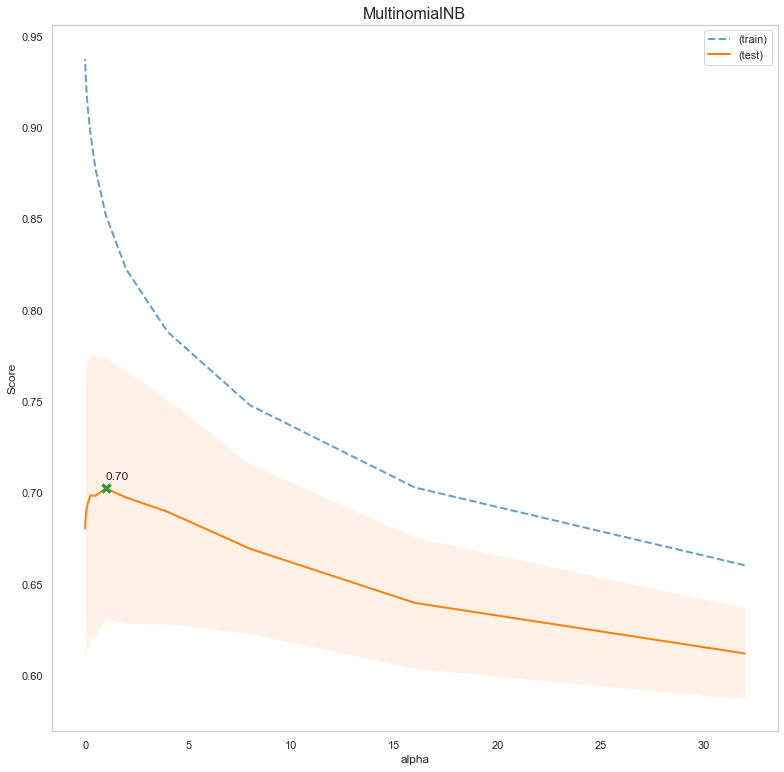

In [114]:
from sklearn.model_selection import GridSearchCV

grid_search_multinomial = GridSearchCV(multinomial, param_grid={'alpha': [2 ** (-i) for i in range(-5,10)]}, scoring='accuracy', return_train_score=True, n_jobs = -1, cv=10)
grid_search_multinomial.fit(X_train, english_train['HS'])

plot_gridsearch(grid_search_multinomial.cv_results_, 'alpha', models[multinomial])

### Bernoulli Naive Bayes classifier

Best alpha: 1.0 (0.7314444444444446)


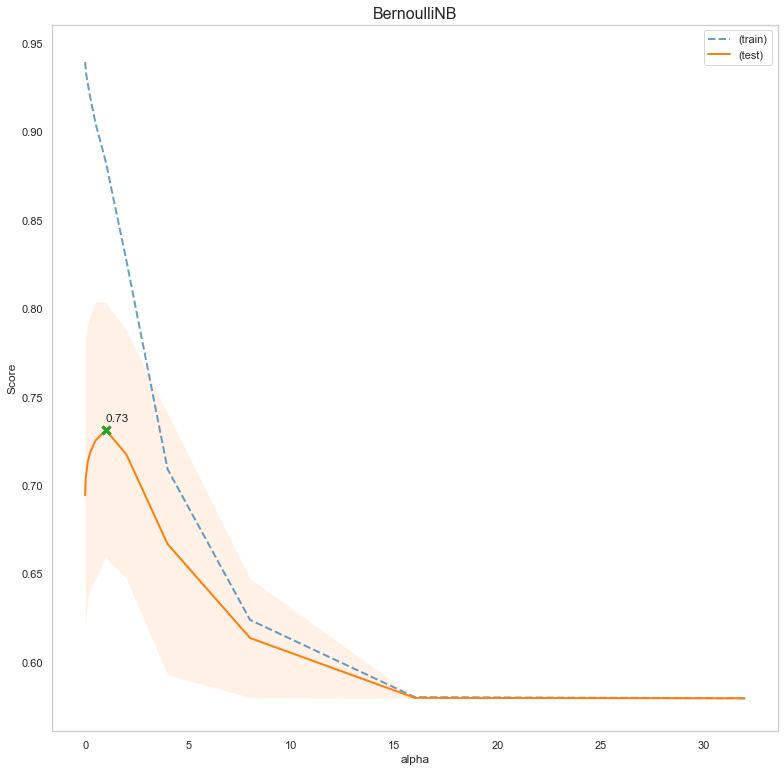

In [117]:
grid_search_bernoulli = GridSearchCV(bernoulli, param_grid={'alpha': [2 ** (-i) for i in range(-5,10)]}, scoring='accuracy', return_train_score=True, n_jobs = -1, cv=10)
grid_search_bernoulli.fit(X_train, english_train['HS'])

plot_gridsearch(grid_search_bernoulli.cv_results_, 'alpha', models[bernoulli])

### Ridge Classifier

Best alpha: 4.0 (0.7403333333333334)


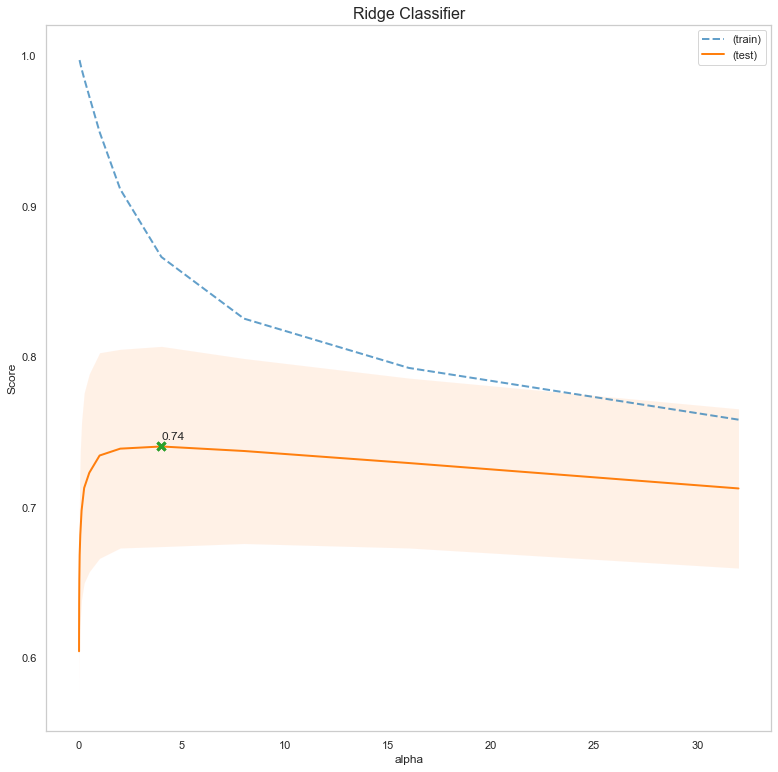

In [119]:
grid_search_ridge = GridSearchCV(ridge, param_grid={'alpha': [2 ** (-i) for i in range(-5,10)]}, scoring='accuracy', return_train_score=True, n_jobs=-1, cv=10)
grid_search_ridge.fit(X_train, english_train['HS'])

plot_gridsearch(grid_search_ridge.cv_results_, 'alpha', models[ridge])

### Random Forest classifier

In [18]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [2 ** (i) for i in range(1,10)] + [None],
    'n_estimators': [2 ** (i) for i in range(1,10)],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
}

grid_search_random_forest = GridSearchCV(random_forest,
                  param_grid=param_grid,
                  scoring='accuracy', return_train_score=True, verbose=1, n_jobs=-1, cv=5)
grid_search_random_forest.fit(X_train, english_train['HS'])

print(grid_search_random_forest.best_params_)

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 44.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 46.1min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 52.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 84.1min
[Parallel(n_jobs=-1)]: Done 8100 out of 8100 | elapsed: 121.8min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [2, 4, 8, 16, 32, 64, 128, 256, 512,
                                       None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [2, 4, 8, 16, 32, 64, 128, 256, 512]},
             return_train_score=True, scoring='accuracy', verbose=1)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 14.6min finished


Best max_features: 0.0625 (0.7483333333333333)


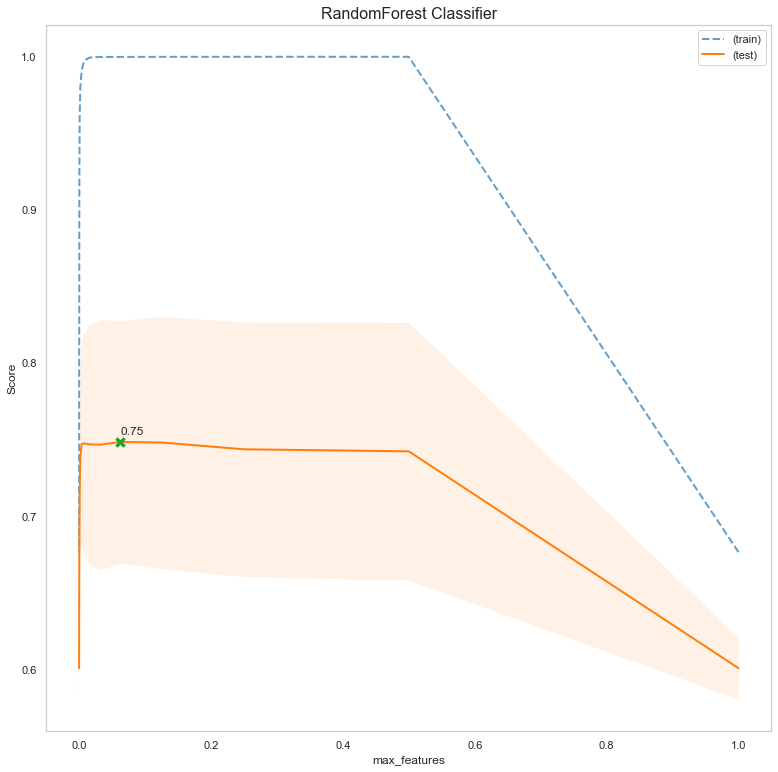

In [120]:
grid_search_random_forest_2 = GridSearchCV(RandomForestClassifier(bootstrap=True, max_depth=256, min_samples_leaf=1, min_samples_split=5, n_estimators=256, random_state=42),
                  param_grid={'max_features': [2 ** (-i) for i in range(16)] + [X_train.shape[1] ** 0.5, np.log2(X_train.shape[1])]}, # last two = sqrt and log2
                  scoring='accuracy', return_train_score=True, verbose=1, n_jobs = -1, cv=10)
 
grid_search_random_forest_2.fit(X_train, english_train['HS'])
plot_gridsearch(grid_search_random_forest_2.cv_results_, 'max_features', models[random_forest])

### Support Vector Classification

In [68]:
param_grid = [{'kernel': ['rbf', 'linear', 'sigmoid'], 'C': [2 ** i for i in range(10)]},
              {'kernel': ['poly'], 'degree': range(2,5), 'C': [2 ** i for i in range(10)]}]

grid_search_svc = GridSearchCV(svc,
                  param_grid=param_grid,
                  scoring='accuracy', return_train_score=True, verbose=1, n_jobs=-1, cv=10)
grid_search_svc.fit(X_train, english_train['HS'])

print(grid_search_svc.best_params_)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 64.5min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 82.1min finished


{'C': 128, 'kernel': 'rbf'}


In [88]:
for i in np.flip(grid_search_svc.cv_results_['mean_test_score'].argsort())[:10]:
    print(grid_search_svc.cv_results_['mean_test_score'][i], grid_search_svc.cv_results_['mean_train_score'][i], grid_search_svc.cv_results_['params'][i])

0.7401111111111112 0.9108518518518519 {'C': 128, 'kernel': 'rbf'}
0.7365555555555556 0.9116666666666665 {'C': 1, 'kernel': 'linear'}
0.7354444444444445 0.9550864197530864 {'C': 256, 'kernel': 'rbf'}
0.7351111111111112 0.8448148148148148 {'C': 64, 'kernel': 'rbf'}
0.7278888888888889 0.9499259259259258 {'C': 2, 'kernel': 'linear'}
0.7272222222222223 0.9801358024691359 {'C': 512, 'kernel': 'rbf'}
0.7236666666666667 0.7846049382716049 {'C': 32, 'kernel': 'rbf'}
0.7213333333333333 0.9727901234567902 {'C': 4, 'kernel': 'linear'}
0.7088888888888889 0.9859876543209876 {'C': 8, 'kernel': 'linear'}
0.7003333333333334 0.9937037037037036 {'C': 16, 'kernel': 'linear'}


In [96]:
grid_search_svc_2 = GridSearchCV(SVC(C=128, kernel='rbf', random_state=42),
                  param_grid={'gamma': [1.1 ** i for i in range(-20,5)] + ['scale', 'auto']},
                  scoring='accuracy', return_train_score=True, verbose=1, n_jobs = -1, cv=10)
 
grid_search_svc_2.fit(X_train, english_train['HS'])
print(grid_search_svc_2.best_params_)

{'gamma': 'scale'}


### AdaBoost Classifier

In [99]:
param_grid = {'n_estimators': [2 ** (i) for i in range(1,10)],
              'learning_rate': [0.1 * (i) for i in range(5,15)],
              'algorithm': ['SAMME', 'SAMME.R']
              }

grid_search_adaboost = GridSearchCV(adaboost,
                  param_grid=param_grid,
                  scoring='accuracy', return_train_score=True, verbose=1, n_jobs=-1, cv=10)
grid_search_adaboost.fit(X_train, english_train['HS'])

print(grid_search_adaboost.best_params_)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 34.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 51.0min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 52.9min finished


{'algorithm': 'SAMME.R', 'learning_rate': 1.2000000000000002, 'n_estimators': 16}


### MLP Classifier

In [103]:
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['adam'],
    'beta_1': [0.1 * i for i in range(9,12)],
    'beta_2': [0.95 + 0.01 * i for i in range(3)],
    'epsilon': [5e-9 + 1e-9 * i for i in range(3)],
}

grid_search_mlp = GridSearchCV(mlp,
                  param_grid=param_grid,
                  scoring='accuracy', return_train_score=True, verbose=2, n_jobs=-1, cv=5)
grid_search_mlp.fit(X_train, english_train['HS'])

print(grid_search_mlp.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 40.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 40.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 63.1min
[Parallel(n_jobs=-1)]: Done 1085 tasks      | elapsed: 85.4min
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed: 86.6min finished


{'activation': 'relu', 'beta_1': 0.9, 'beta_2': 0.95, 'epsilon': 7e-09, 'hidden_layer_sizes': (50, 50, 50), 'solver': 'adam'}


## Best Models

In [110]:
#Dummy is same
best_multinomial = MultinomialNB(alpha=1)
best_bernoulli = BernoulliNB(alpha=1)
best_ridge = RidgeClassifier(alpha=4, random_state=42)
best_random_forest = RandomForestClassifier(bootstrap=True, max_depth=256, min_samples_leaf=1, min_samples_split=5, n_estimators=256, max_features=0.0625, random_state=42)
best_mlp = MLPClassifier(solver='adam', activation='relu', beta_1=0.9, beta_2=0.95, early_stopping=True, epsilon=7e-09, hidden_layer_sizes=(50, 50, 50), random_state=42)
best_svc = SVC(random_state=42)
best_adaboost = AdaBoostClassifier(algorithm='SAMME.R', learning_rate=1.2, n_estimators=16, random_state=42)

best_models = {
    dummy: "Dummy Classifier",
    best_multinomial: "Best Multinomial Naive Bayes classifier",
    best_bernoulli: "Best Bernoulli Naive Bayes classifier",
    best_ridge: "Best Ridge Classifier",
    best_random_forest: "Best Random Forest classifier",
    best_svc: "Best Support Vector Classification",
    best_adaboost: "Best AdaBoost classifier",
    best_mlp: "Best Multi-layer Perceptron classifier"
}
fit_models(X_train, english_train['HS'], best_models)

print("TRAIN:")
print_scores(X_train, english_train["HS"], best_models)

print("\n\nDEV:")
print_scores(X_dev, english_dev["HS"], best_models)

Model Dummy Classifier fitted
Model Best Multinomial Naive Bayes classifier fitted
Model Best Bernoulli Naive Bayes classifier fitted
Model Best Ridge Classifier fitted
Model Best Random Forest classifier fitted
Model Best Support Vector Classification fitted
Model Best AdaBoost classifier fitted
Model Best Multi-layer Perceptron classifier fitted
TRAIN:
Dummy Classifier

 Accuracy:  0.5796666666666667

Classification Report

               precision    recall  f1-score   support

           0       1.00      0.58      0.73      9000
           1       0.00      0.00      0.00         0

    accuracy                           0.58      9000
   macro avg       0.50      0.29      0.37      9000
weighted avg       1.00      0.58      0.73      9000

Best Multinomial Naive Bayes classifier

 Accuracy:  0.8468888888888889

Classification Report

               precision    recall  f1-score   support

           0       0.90      0.85      0.87      5561
           1       0.77      0.85   

C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best Random Forest classifier

 Accuracy:  1.0

Classification Report

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5217
           1       1.00      1.00      1.00      3783

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000

Best Support Vector Classification

 Accuracy:  0.6112222222222222

Classification Report

               precision    recall  f1-score   support

           0       0.95      0.60      0.74      8210
           1       0.14      0.68      0.23       790

    accuracy                           0.61      9000
   macro avg       0.55      0.64      0.49      9000
weighted avg       0.88      0.61      0.70      9000

Best AdaBoost classifier

 Accuracy:  0.7644444444444445

Classification Report

               precision    recall  f1-score   support

           0       0.87      0.76      0.81  